# Mining via refining
It is too expensive to find all concatenations immediately.
So go through a series of refinements.

1) First find sheets where values overlap.
2) Then from them find moves.
3) Then moves where the max of the one is the min of the other.

Find all where the overlap is more than 10.
Find moves where the move size is more than 10.

In [65]:
import numpy as np
from scipy.sparse import load_npz
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import duckdb


In [3]:
x_file='../experiments/results/data.npz'
top_file='../experiments/results/top20.npz'
k = 20
# Load from disk
print('Loading')
x = load_npz(x_file)
topo = np.load(top_file)
top = topo['arr_0']
print('Loaded', x.shape, top.shape)


Loading
Loaded (279699, 8591565) (279699, 20)


In [4]:
top

array([[110934, 110933, 110966, ..., 110827, 110835, 110862],
       [ 98620,  98619,  98634, ...,  98637,  98613,  98612],
       [  4609,   4608, 115752, ..., 115790, 115739,   4604],
       ...,
       [189370, 189080, 190774, ..., 187606, 187899, 187896],
       [129110, 129113, 129088, ..., 129135, 129136, 129134],
       [146183, 275714, 147536, ..., 146469, 146190, 146186]], dtype=int32)

In [6]:

x_lil = x.tolil()
x_set = [
    set(row)
    for row in x_lil.rows
]

topa = top
scores = []

for i, xs in enumerate(tqdm.tqdm(x_set)):
    for j in range(k):
        j_ind = topa[i, j]
        sa = x_set[i] & x_set[j_ind]
        scores.append((i, j_ind, len(sa)))

# Sorting
scores = [(i, j, sa) for i ,j, sa in scores]

scores = sorted(scores, key=lambda x: x[2], reverse=True)

100%|██████████| 279699/279699 [00:16<00:00, 16738.26it/s]


In [9]:
scores[:10]

[(57646, np.int32(57646), 393),
 (46072, np.int32(46072), 360),
 (218328, np.int32(218328), 332),
 (78001, np.int32(78001), 319),
 (9407, np.int32(9407), 300),
 (9408, np.int32(9408), 300),
 (159154, np.int32(159154), 289),
 (129896, np.int32(129896), 274),
 (132694, np.int32(132694), 258),
 (9407, np.int32(9408), 248)]

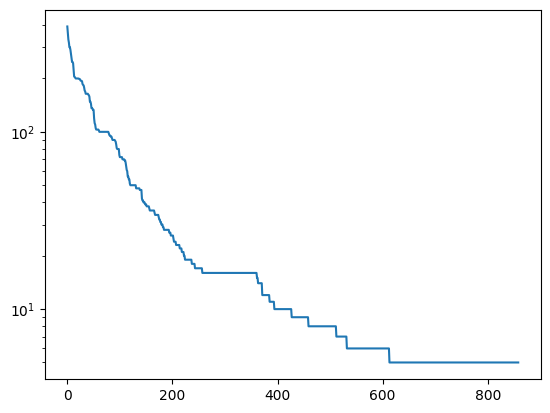

In [69]:
# Plot the scores
n_contains = 5
plt.plot([s[2] for s in scores if s[2] >= n_contains])
# y log
plt.yscale('log')

In [56]:
# Now find the moves
# First, load all fs, i, j, v where fs has a score >= 10
res = duckdb.sql(f"""
with A as (
    select * from '../experiments/results/parquet_tall/df_*.parquet'
    where fs in ({','.join([str(s[0]) for s in scores if s[2] >= n_contains])})
)
select * from A
""")
dfr = res.to_df()
dfr.shape

(15292, 5)

In [57]:
dfr.head()

,index,fs,i,j,v
0,1559202,3518,5,2,54035
1,1559203,3518,5,3,54100
2,1559300,3518,6,0,54139
3,1559301,3518,6,1,54126
4,1559302,3518,6,2,54080


In [59]:
n_move_size = 5
# Now find the moves by joining on value
res = duckdb.sql(f"""
with A as (
    select * from '../experiments/results/parquet_tall/df_*.parquet'
    where fs in ({','.join([str(s[0]) for s in scores if s[2] >= n_contains])})
),
diff as (
    select a.fs as afs, b.fs as bfs, a.v as v, cast(a.i as int) - b.i as di, cast(a.j as int) - b.j as dj,
        a.i as i1, a.j as j1, b.i as i2, b.j as j2
    from A as a join A as b
    on a.v = b.v and a.fs < b.fs
),
moves as (
    select afs, bfs, di, dj, count(*) as move_size,
        min(i1) as mini1, min(j1) as minj1, max(i1) as maxi1, max(j1) as maxj1,
        min(i2) as mini2, min(j2) as minj2, max(i2) as maxi2, max(j2) as max2j
    from diff
    group by afs, bfs, di, dj
    having move_size > {n_move_size}
)
select * from moves
""")
df_moves = res.to_df()
print(df_moves.shape)
df_moves

(545, 13)


,afs,bfs,di,dj,move_size,mini1,minj1,maxi1,maxj1,mini2,minj2,maxi2,max2j
0,129896,252145,0,2,47,1,2,77,3,1,0,77,1
1,129896,238757,6,2,7,54,2,58,3,48,0,52,1
2,182505,211745,43,0,15,73,0,84,1,30,0,41,1
3,182505,211745,47,0,10,48,0,72,0,1,0,25,0
4,43752,272411,1,0,14,2,1,31,1,1,1,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,170749,212719,0,0,8,0,0,0,7,0,0,0,7
541,66294,66301,0,0,8,0,0,2,4,0,0,2,4
542,14790,43752,0,0,64,0,0,31,1,0,0,31,1
543,14790,43752,-2,0,8,12,1,24,1,14,1,26,1


In [60]:
df_moves.query('afs == 114673')

,afs,bfs,di,dj,move_size,mini1,minj1,maxi1,maxj1,mini2,minj2,maxi2,max2j
72,114673,208803,0,0,18,0,0,18,0,0,0,18,0
482,114673,208803,-2,0,19,19,0,37,0,21,0,39,0


In [61]:
df_moves.query('bfs == 114673')

,afs,bfs,di,dj,move_size,mini1,minj1,maxi1,maxj1,mini2,minj2,maxi2,max2j
27,26289,114673,-6,0,6,26,0,31,0,32,0,37,0
54,71552,114673,0,0,8,0,0,24,0,0,0,24,0
93,26289,114673,-2,0,8,3,0,20,0,5,0,22,0
128,71552,114673,1,0,15,9,0,23,0,8,0,22,0
129,71552,114673,-2,0,11,25,0,35,0,27,0,37,0
356,26289,114673,0,0,6,0,0,14,0,0,0,14,0
385,71694,114673,0,0,23,0,0,22,0,0,0,22,0
539,71694,114673,-1,0,13,23,0,36,0,24,0,37,0


In [62]:
# Now find triples where the same sheet is involved with two moves
res = duckdb.sql(f"""
with move_rels as (
    select distinct afs, bfs from df_moves
),
move_counts as (
    select afs as fs, count(*) as cnt from move_rels group by afs
    union all
    select bfs as fs, count(*) as cnt from move_rels group by bfs
)
select fs, sum(cnt) as cnt
from move_counts
group by fs
having cnt >= 3
order by cnt desc
""")
df_triple_candidates = res.to_df()
print(df_triple_candidates.shape)
df_triple_candidates

(18, 2)


,fs,cnt
0,139818,6.0
1,244151,6.0
2,16124,6.0
3,78535,6.0
4,90822,6.0
5,250852,6.0
6,230005,6.0
7,26289,4.0
8,208803,4.0
9,114673,4.0


In [67]:
# Now find the moves where the max of one is the min of the other
moves = []
for fs in df_triple_candidates.fs:
    fso = df_moves.query('afs == @fs')
    print(fs, fso.shape)
    if len(fso) < 2:
        print(f"Skipping {fs} as it has only {len(fso)} move")
        continue
    target_mini = []
    target_minj = []
    target_maxi = []
    target_maxj = []
    source_fs = []
    for i, row in fso.iterrows():
        if row['afs'] == fs:  # target <- source
            source_fs.append(row['bfs'])
            target_mini.append(row['mini1'])
            target_minj.append(row['minj1'])
            target_maxi.append(row['maxi1'])
            target_maxj.append(row['maxj1'])
        else:  # target <- source
            source_fs.append(row['afs'])
            target_mini.append(row['mini2'])
            target_minj.append(row['minj2'])
            target_maxi.append(row['maxi2'])
            target_maxj.append(row['maxj2'])
    # Now find the moves where the max of one is the min of the other
    for s1, mini in enumerate(target_mini):
        for s2, maxi in enumerate(target_maxi):
            if maxi + 1 == mini:
                print(f"Found concat: {source_fs[s1]} -> {fs} <- {source_fs[s2]}  {maxi}:{mini}")
                moves.append((fs, source_fs[s1], source_fs[s2], maxi, mini))
df_concat = pd.DataFrame(moves, columns=['fs', 'source1', 'source2', 'maxi', 'mini'])

139818 (3, 13)
244151 (1, 13)
Skipping 244151 as it has only 1 move
16124 (6, 13)
78535 (5, 13)
90822 (4, 13)
250852 (0, 13)
Skipping 250852 as it has only 0 move
230005 (2, 13)
26289 (11, 13)
Found concat: 114673 -> 26289 <- 71552  25:26
Found concat: 71694 -> 26289 <- 71552  25:26
Found concat: 208803 -> 26289 <- 71552  25:26
Found concat: 71552 -> 26289 <- 71552  25:26
Found concat: 71552 -> 26289 <- 208803  14:15
Found concat: 71552 -> 26289 <- 114673  14:15
Found concat: 71552 -> 26289 <- 71694  14:15
208803 (0, 13)
Skipping 208803 as it has only 0 move
114673 (2, 13)
Found concat: 208803 -> 114673 <- 208803  18:19
71694 (4, 13)
Found concat: 114673 -> 71694 <- 114673  22:23
71552 (9, 13)
Found concat: 114673 -> 71552 <- 114673  24:25
Found concat: 114673 -> 71552 <- 71694  24:25
Found concat: 208803 -> 71552 <- 114673  24:25
Found concat: 208803 -> 71552 <- 71694  24:25
Found concat: 71694 -> 71552 <- 114673  24:25
Found concat: 71694 -> 71552 <- 71694  24:25
68949 (10, 13)
Found

In [68]:
print(df_concat.shape)
df_moves.query('afs == 208803 or bfs == 208803')

(28, 5)


,afs,bfs,di,dj,move_size,mini1,minj1,maxi1,maxj1,mini2,minj2,maxi2,max2j
72,114673,208803,0,0,18,0,0,18,0,0,0,18,0
161,26289,208803,0,0,6,0,0,14,0,0,0,14,0
162,26289,208803,-8,0,6,26,0,31,0,34,0,39,0
198,71552,208803,-4,0,11,25,0,35,0,29,0,39,0
263,71694,208803,0,0,18,0,0,18,0,0,0,18,0
321,71552,208803,1,0,10,9,0,19,0,8,0,18,0
386,71694,208803,-3,0,14,17,0,36,0,20,0,39,0
468,71552,208803,0,0,7,0,0,6,0,0,0,6,0
482,114673,208803,-2,0,19,19,0,37,0,21,0,39,0


In [70]:
# Now find joins

1508  / 60

25.133333333333333

In [71]:
5256 / 60

87.6